# BO for the 2D case

This notebook showcases how we can go from the 1D case to the 2D case with minimum changes to the helper functions.

This time we are maximizing a simpler bellcurve function.

In [11]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
import warnings
import random
warnings.filterwarnings("ignore") # Not the best

plt.style.use('fivethirtyeight')

## 2D function optimization with noise

In [12]:
def objective(x1, x2, noise_scale=1):
    noise = np.random.normal(loc=0, scale=noise_scale)
    return (4*np.exp(-x1**2) + 6*np.exp(-4*x2**2)) + noise

In [13]:
X1_ax = np.arange(-5, 5, 0.1).reshape(-1,1)
X2_ax = np.arange(-5, 5, 0.1).reshape(-1,1)
X_all = np.array(np.meshgrid(X1_ax.reshape(-1,), X2_ax.reshape(-1,))).T.reshape(-1,2)
y_ax = np.array([objective(x1, x2, 0) for x1 in X1_ax for x2 in X2_ax])
ynoise = np.array([objective(x1, x2) for x1 in X1_ax for x2 in X2_ax])

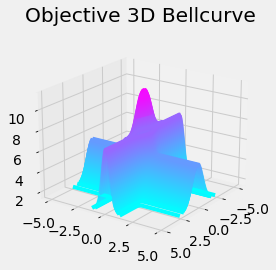

In [14]:
x = np.arange(-5, 5, 0.1).reshape(-1,1)
y = np.arange(-5, 5, 0.1).reshape(-1,1)

X, Y = np.meshgrid(x, y)
Z = objective(X, Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 100, cmap='cool')
ax.view_init(20, 35)
plt.title("Objective 3D Bellcurve")
plt.savefig("./figs/bo_3d_bell")
plt.show()

In [15]:
n = 5
idx = random.sample(range(0, len(X_all)-1), n)
y_idx = objective(X_all[idx][:, 0], X_all[idx][:, 1], 0)
data = np.hstack((X_all[idx], y_idx.reshape(-1,1)))
np.round(data,2)

array([[-2.8 , -3.  ,  0.  ],
       [ 0.2 , -4.3 ,  3.84],
       [-2.  ,  3.1 ,  0.07],
       [-1.4 , -2.6 ,  0.56],
       [ 0.3 ,  4.4 ,  3.66]])

In [16]:
X = data[:, :2]
y = data[:, -1]

In [17]:
model = GaussianProcessRegressor()
model.fit(X, y)

GaussianProcessRegressor()

# *Helpers*

In [18]:
def objective(x1, x2, noise_scale=1):
    # max (x1, x2) = (0, 0)
    noise = np.random.normal(loc=0, scale=noise_scale)
    return (4*np.exp(-1*x1**2) + 6*np.exp(-4*x2**2)) + noise
    # return (x*np.sin(10*x)) + noise


def surrogate(model, X):
    return model.predict(X, return_std=True)


def acq_pi(X, Xsamples, model, beta=None):
    yhat, _ = surrogate(model, X)
    best = max(yhat) # calculate the best so far

    mu, std = surrogate(model, Xsamples)
    mu = mu.reshape(-1,1)[:, 0]
    gamma = (mu - best) / (std + 1E-9)
    probs = norm.cdf(gamma) # add a very small number to std to avoid dividing with 0
    return probs


def acq_ei(X, Xsamples, model, beta=None):
    yhat, _ = surrogate(model, X)
    best = max(yhat) # calculate the best so far

    mu, std = surrogate(model, Xsamples)
    mu = mu.reshape(-1,1)[:, 0]
    gamma = (mu-best)/(std + 1E-9) # add a very small number to std to avoid dividing with 0
    probs = std * (gamma * norm.cdf(gamma)) + norm.pdf(gamma)
    return probs

def acq_ucb(X, Xsamples, model, beta=1):
    yhat, _ = surrogate(model, X)
    mu, std = surrogate(model, Xsamples)
    mu = mu.reshape(-1, 1)[:, 0]
    probs = mu + np.sqrt(beta)*std
    return probs

def opt_acq(X, y, model, acq, low, high, beta=0.5):
    Xsamples = get_random_X(low=low, high=high, samples=10000)
    scores = acq(X, Xsamples, model, beta=beta)
    ix = np.argmax(scores)
    return Xsamples[ix]

def get_random_X(low, high, samples):
    ALL = np.array(np.meshgrid(*[np.arange(low[k], high[k], 0.01) for k in range(len(low))])).T.reshape(-1,len(low))
    idx = random.sample(range(0, ALL.shape[0]-1), samples)
    return ALL[idx]

# Optimization loop

In [19]:
def random_start_loop(low=[-5, -5], high=[5, 5], n=5, noise=0.01, kernel=None):
    X = get_random_X(low=low, high=high, samples=n)
    y = objective(X[:, 0], X[:, 1], noise).reshape(-1,1) # Evaluation with noise
    model = GaussianProcessRegressor(kernel=kernel)
    model.fit(X, y)
    return X, y, model


def bo_loop(n, X, y, model, noise, acq, low=[-5, -5], high=[5, 5], beta=None):
    for i in range(n):
        x = opt_acq(X=X, y=y, model=model, acq=acq, low=low, high=high, beta=beta)
        actual = objective(x[0], x[1], noise)
        est, _ = surrogate(model, np.array(x).reshape(-1,len(low)))

        X = np.vstack((X, x))
        y = np.vstack((y, [[actual]]))
        model.fit(X, y)
    return X, y, model

# Initial Sampling

In [61]:
kernel = None
noise_lvl = 0.01
X_init, y_init, model = random_start_loop(low=[-5, -5], high=[5, 5], n=10, noise=noise_lvl, kernel=kernel)

### Optimization loop

In [62]:
X, y, model = bo_loop(n=50, X=X_init, y=y_init, model=model, noise=noise_lvl, acq=acq_ucb, low=[-5, -5], high=[5, 5], beta=0.1)

In [63]:
print(np.round(X[np.argmax(y)],2))
print(y[np.argmax(y)])

[ 0.09 -0.  ]
[9.95056975]


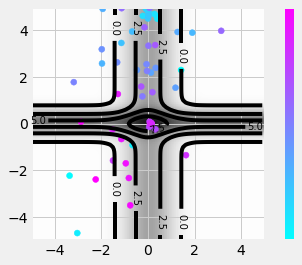

In [64]:
X1_ax = np.arange(-5, 5, 0.1).reshape(-1,1)
X2_ax = np.arange(-5, 5, 0.1).reshape(-1,1)
X_mesh, Y_mesh = np.meshgrid(X1_ax, X2_ax)
Z = objective(X_mesh, Y_mesh)
fig, ax=plt.subplots(1,1)
contours = plt.contour(X_mesh, Y_mesh, Z, 3, colors='black')
plt.scatter(X[5:, 0], X[5:, 1], c=np.arange(-5, 5.9, 0.2), cmap='cool')
plt.colorbar().set_ticks([])
plt.clabel(contours, inline=True, fontsize=10)
zoom = 5.
plt.imshow(Z, extent=[-zoom, zoom, -zoom, zoom], origin='lower',
           cmap='binary', alpha=0.9)
plt.savefig("./figs/bo_3d_movement.png")
plt.show()